In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/autoencoder-anomaly-detection/autoencoder-anomaly-detection.zip
!unzip -qq autoencoder-anomaly-detection.zip
%cd autoencoder-anomaly-detection

--2023-08-28 02:28:41--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/autoencoder-anomaly-detection/autoencoder-anomaly-detection.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 3.5.81.19, 3.5.82.182, 52.92.132.154, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|3.5.81.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3169538 (3.0M) [binary/octet-stream]
Saving to: ‘autoencoder-anomaly-detection.zip’

autoencoder-anomaly 100%[===================>]   3.02M  6.86MB/s    in 0.4s    

2023-08-28 02:28:42 (6.86 MB/s) - ‘autoencoder-anomaly-detection.zip’ saved [3169538/3169538]

/content/autoencoder-anomaly-detection


In [2]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2

In [3]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [4]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:

			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)),
			name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

In [11]:
def build_unsupervised_dataset(data, labels, validLabel = 1,
                               anomalyLabel=3, contam=0.01, seed=42):
  validIdxs = np.where(labels == validLabel)[0]
  anomalyIdxs = np.where(labels ==anomalyLabel)[0]

  random.shuffle(validIdxs)
  random.shuffle(anomalyIdxs)

  i = int(len(validIdxs) * contam)
  anomalyIdxs = anomalyIdxs[:i]

  validImages = data[validIdxs]
  anomalyImages = data[anomalyIdxs]

  images = np.vstack([validImages, anomalyImages])
  np.random.seed(seed)
  np.random.shuffle(images)

  return images

In [12]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [13]:
args = {
	"dataset": "output/images.pickle",
	"model": "output/autoencoder.model",
	"vis": "recon_vis.png",
	"plot": "plot.png"
}

In [14]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
	anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,
	random_state=42)

[INFO] loading MNIST dataset...
[INFO] creating unsupervised dataset...


In [17]:
import tensorflow as tf
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
171/171 [==============================] - 11s 9ms/step - loss: 0.0395 - val_loss: 0.0408
Epoch 2/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0124 - val_loss: 0.0327
Epoch 3/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0114
Epoch 4/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 5/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/20
171/171 [==============================] - 2s 10ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/20
171/171 [==============================] - 2s 11ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/20
171/171 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/20
171/171 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0

[INFO] making predictions...
43/43 [==============================] - 0s 2ms/step


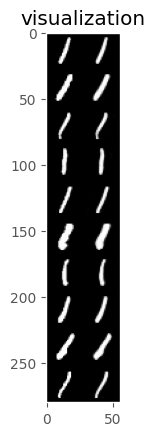

In [20]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(args["vis"], vis)
plt_imshow("visualization", vis)

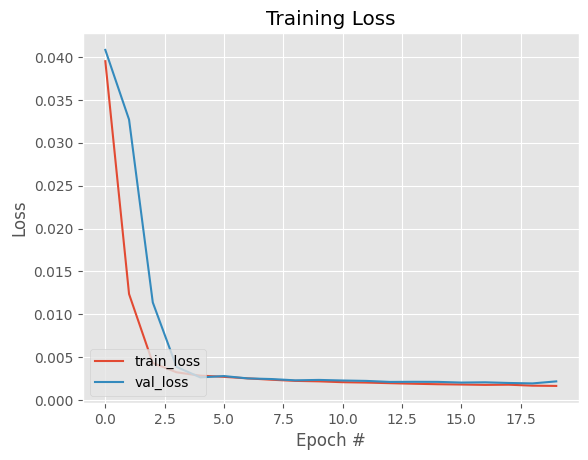

[INFO] saving image data...
[INFO] saving autoencoder...


In [19]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

# serialize the image data to disk
print("[INFO] saving image data...")
f = open(args["dataset"], "wb")
f.write(pickle.dumps(images))
f.close()

# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args["model"], save_format="h5")

In [21]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle
import cv2

In [22]:
args = {
	"dataset": "output/images.pickle",
	"model": "output/autoencoder.model",
	"quantile": 0.999
}

In [23]:
# load the model and image data from disk
print("[INFO] loading autoencoder and image data...")
autoencoder = load_model(args["model"])
images = pickle.loads(open(args["dataset"], "rb").read())

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

[INFO] loading autoencoder and image data...
213/213 [==============================] - 1s 5ms/step


In [24]:
thresh = np.quantile(errors, args["quantile"])
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.024420889511704454
[INFO] 7 outliers found


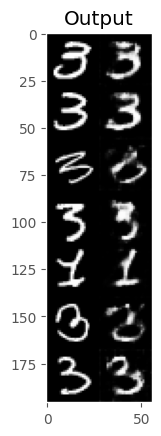

In [25]:
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (images[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt_imshow("Output", outputs)